In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import joblib
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score
from scipy.sparse import load_npz
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import gensim.downloader
from sklearn.utils import resample
import string
import pickle
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Fall 2024/SML 312/Final Project/data'

train_df = pd.read_csv(file_path + '/train.csv')
test_df = pd.read_csv(file_path + '/test.csv')

Mounted at /content/drive


In [ ]:
# Load precomputed features from FeatureEngineering.ipynb

tfidf_train = np.load(file_path + '/tfidf_train.npy')
tfidf_test = np.load(file_path + '/tfidf_test.npy')

tfidf_feature_names = np.load(file_path + '/tfidf_feature_names.npy', allow_pickle=True)

word2vec_train = np.load(file_path + '/word2vec_train.npy')
word2vec_test = np.load(file_path + '/word2vec_test.npy')

word2vec_smote_tomek_embeddings = np.load(file_path + '/word2vec_smote_tomek_embeddings.npy')
word2vec_smote_tomek_labels = np.load(file_path + '/word2vec_smote_tomek_labels.npy')

lda_train = pd.read_pickle(file_path + '/lda_train.pkl')
lda_test = pd.read_pickle(file_path + '/lda_test.pkl')

with open(file_path + '/lda_topics.pkl', 'rb') as f:
  lda_topics = pickle.load(f)

In [ ]:
word2vec_feature_names = [f"embedding_{i+1}" for i in range(word2vec_train.shape[1])]

lda_feature_names = [f"topic_{i+1}" for i in range(lda_train.shape[1])]

In [ ]:
train_df['clean_prompt'] = train_df['clean_prompt'].fillna('')
test_df['clean_prompt'] = test_df['clean_prompt'].fillna('')

In [ ]:
# Function for viewing evaluation metrics

def evaluation_metrics(title, y_pred_prob, y_true, threshold=0.5, plots=True):
  y_pred = (y_pred_prob >= threshold).astype(int)

  precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
  pr_auc = auc(recall, precision)

  accuracy, recall, _f1_score = accuracy_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)

  results = pd.DataFrame({
    'Model': [title],
    'Accuracy': [accuracy],
    'Recall': [recall],
    'F1-Score': [_f1_score],
    'Precision-Recall AUC': [pr_auc]
  })

  print(f"=== {title} Classification Report ===")
  print(results)

  if plots:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Benign', 'Jailbreak'])
    disp.plot(ax=axes[0], cmap=plt.cm.Blues)
    axes[0].set_title(title + ' Confusion Matrix')

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

    axes[1].plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(title + ' Precision-Recall Curve')
    axes[1].legend(loc="lower left")

    plt.tight_layout()
    plt.show()

    return (results, fig)

  else:
    return (results, None)

In [ ]:
# Visualize top 10 features

def visualize_top_10_features(model, feature_names, title, x_axis='Feature', is_log_reg=False):
  if is_log_reg:
    importances = model.coef_[0]
    y_axis = 'Coefficient'
  else:
    importances = model.feature_importances_
    y_axis = 'Importance'
  feature_importances = pd.DataFrame({
      'Feature': feature_names,
      'Importance': importances
  })
  feature_importances['Abs_Importance'] = feature_importances['Importance'].abs()
  feature_importances = feature_importances.sort_values(by='Abs_Importance', ascending=False)

  top_10_features = feature_importances.head(10)

  plt.figure(figsize=(12, 6))
  sns.barplot(
      x='Feature',
      y='Importance',
      data=top_10_features,
      hue='Feature',
      legend=False,
      palette=sns.color_palette("viridis", 10)
  )
  plt.xticks(rotation=45, ha='right', fontsize=12)
  plt.title(title, fontsize=16)
  plt.xlabel(x_axis, fontsize=14)
  plt.ylabel(y_axis, fontsize=14)
  plt.tight_layout()
  plt.show()

In [ ]:
# Function for viewing top n feature coefficients

def feature_coefs(model, feature_names, top_n=None):
  coefs = model.coef_[0]

  feature_coefs = pd.DataFrame({
      'Feature': feature_names,
      'Coefficient': coefs
  })

  feature_coefs = feature_coefs.sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)

  if top_n:
    print(feature_coefs.head(top_n))
  else:
   print(feature_coefs)

# Function for viewing top n feature importances

def feature_importances(model, feature_names, top_n=None):
  importances = model.feature_importances_

  feature_importances = pd.DataFrame({
      'Feature': feature_names,
      'Importance': importances
  })

  feature_importances = feature_importances.sort_values(by='Importance', key=lambda x: x.abs(), ascending=False)

  if top_n:
    print(feature_importances.head(top_n))
  else:
   print(feature_importances)

=== ZeroR Classifier Classification Report ===
              Model  Accuracy  Recall  F1-Score  Precision-Recall AUC
0  ZeroR Classifier   0.90753     0.0       0.0              0.546235


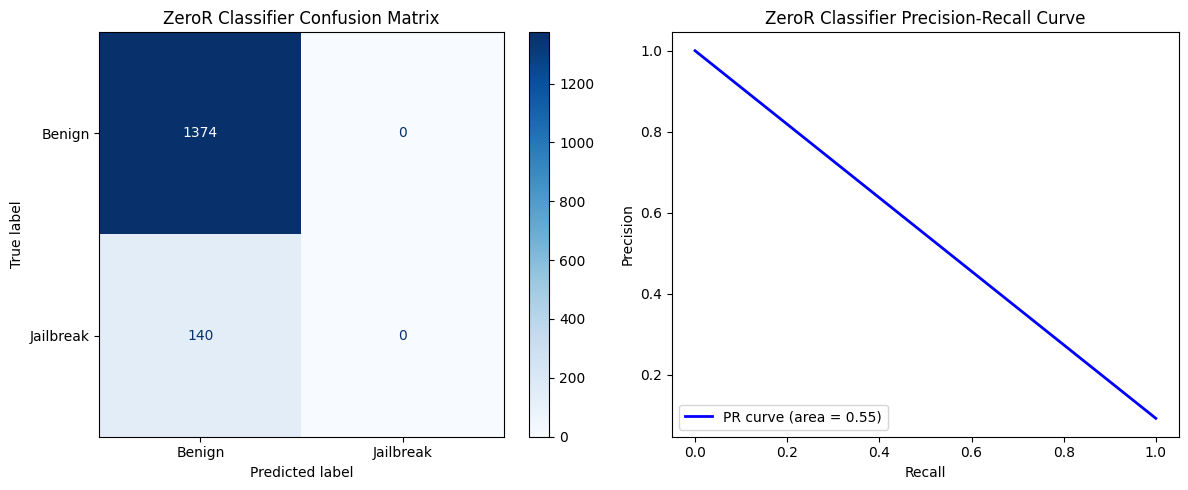

In [ ]:
# Baseline: ZeroR Classifier

zeroR_prediction = np.array([0] * len(test_df))
results_zeroR, fig_zeroR = evaluation_metrics('ZeroR Classifier', zeroR_prediction, test_df['jailbreak'])

=== Logistic Regression (Threshold=0.35) Classification Report ===
                                  Model  Accuracy  Recall  F1-Score  \
0  Logistic Regression (Threshold=0.35)  0.869881     0.9  0.561247   

   Precision-Recall AUC  
0              0.703658  


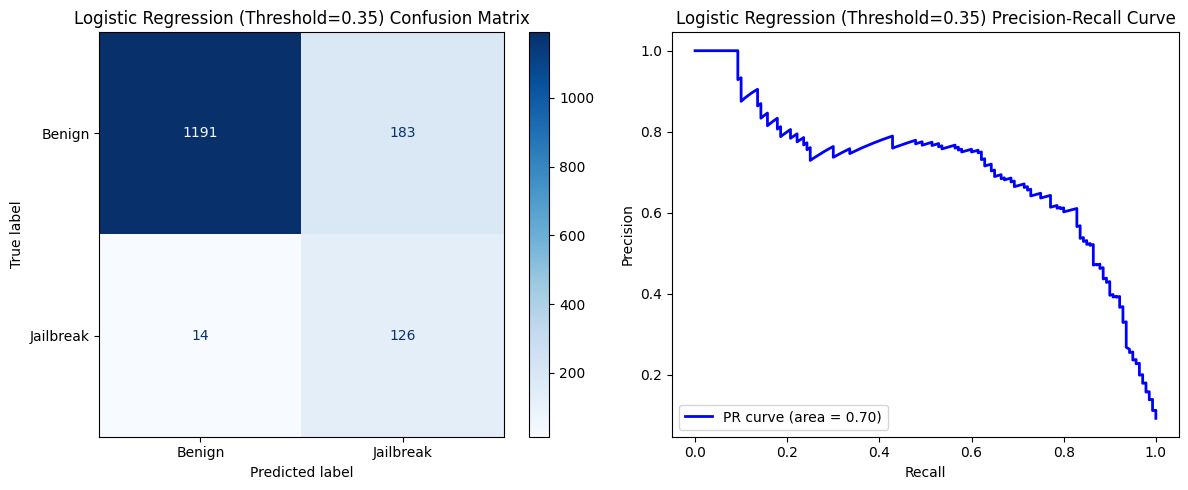

In [ ]:
# Final Logistic Regression
# Features: TF-IDF scores (max_features=3000)
# Parameters: class_weight='balanced', max_iter=1000, threshold=0.35

train_features_log_reg = tfidf_train
test_features_log_reg = tfidf_test

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features_log_reg, train_df['jailbreak'])

y_pred_prob_log_reg = log_reg.predict_proba(test_features_log_reg)[:, 1]

results_log_reg, fig_log_reg = evaluation_metrics('Logistic Regression (Threshold=0.35)', y_pred_prob_log_reg, test_df['jailbreak'], threshold=0.35)

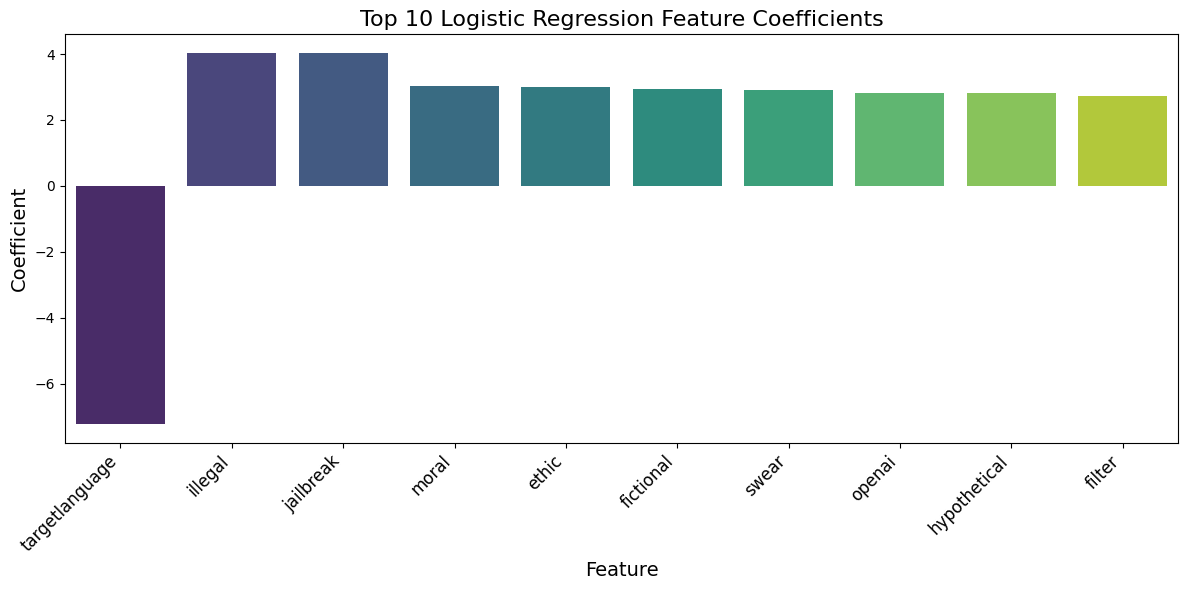

In [ ]:
visualize_top_10_features(log_reg, tfidf_feature_names, 'Top 10 Logistic Regression Feature Coefficients', is_log_reg=True)

In [ ]:
# Logistic Regression Feature Coefficients

print("Logistic Regression Feature Importances")
print("---------------------------------------")
feature_coefs(log_reg, tfidf_feature_names, top_n=10)

Logistic Regression Feature Importances
---------------------------------------
             Feature  Coefficient
2666  targetlanguage    -7.223185
1329         illegal     4.033665
1457       jailbreak     4.020184
1724           moral     3.037550
948            ethic     3.014859
1064       fictional     2.952386
2642           swear     2.905184
1835          openai     2.832418
1320    hypothetical     2.807576
1073          filter     2.716823


=== Random Forest (threshold=0.3) Classification Report ===
                           Model  Accuracy    Recall  F1-Score  \
0  Random Forest (threshold=0.3)  0.842801  0.914286  0.518219   

   Precision-Recall AUC  
0              0.663798  


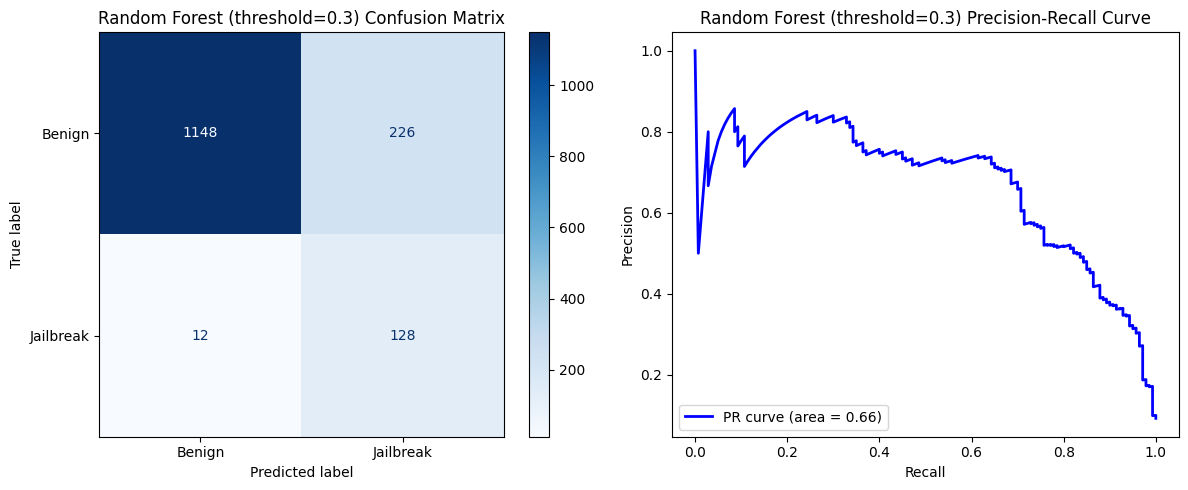

In [ ]:
# Final Random Forest
# Features: Word2Vec embeddings (resampled with Smote and Tomek Links to train model)
# Parameters: n_estimators=100, max_depth=10, random_state=42, threshold=0.3

train_features_rf = word2vec_smote_tomek_embeddings
test_features_rf = word2vec_test

random_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

random_forest.fit(train_features_rf, word2vec_smote_tomek_labels)

y_pred_prob_rf = random_forest.predict_proba(test_features_rf)[:, 1]

results_rf, fig_rf = evaluation_metrics('Random Forest (threshold=0.3)', y_pred_prob_rf, test_df['jailbreak'], threshold=0.3)

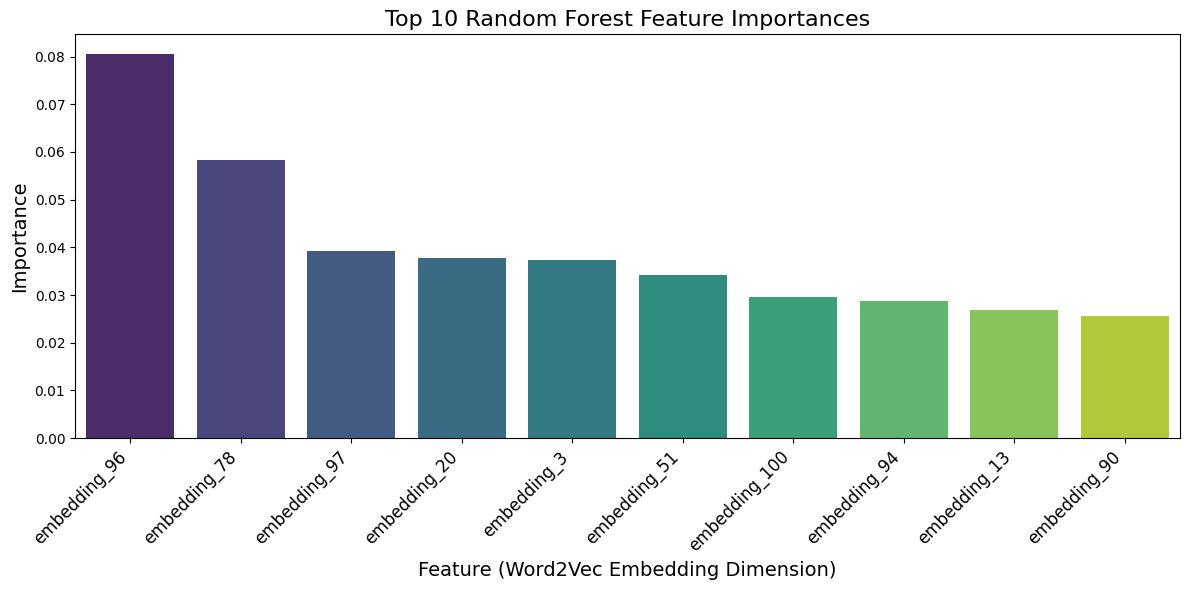

In [ ]:
visualize_top_10_features(random_forest, word2vec_feature_names, 'Top 10 Random Forest Feature Importances', x_axis='Feature (Word2Vec Embedding Dimension)')

In [ ]:
# Random Forest Feature Importances

print("Random Forest Feature Importances")
print("---------------------------------")
feature_importances(random_forest, word2vec_feature_names, 10)

Random Forest Feature Importances
---------------------------------
          Feature  Importance
95   embedding_96    0.080641
77   embedding_78    0.058322
96   embedding_97    0.039234
19   embedding_20    0.037713
2     embedding_3    0.037395
50   embedding_51    0.034179
99  embedding_100    0.029590
93   embedding_94    0.028727
12   embedding_13    0.026944
89   embedding_90    0.025553


=== XGBoost Classification Report ===
     Model  Accuracy  Recall  F1-Score  Precision-Recall AUC
0  XGBoost  0.937913     0.8  0.704403              0.707805


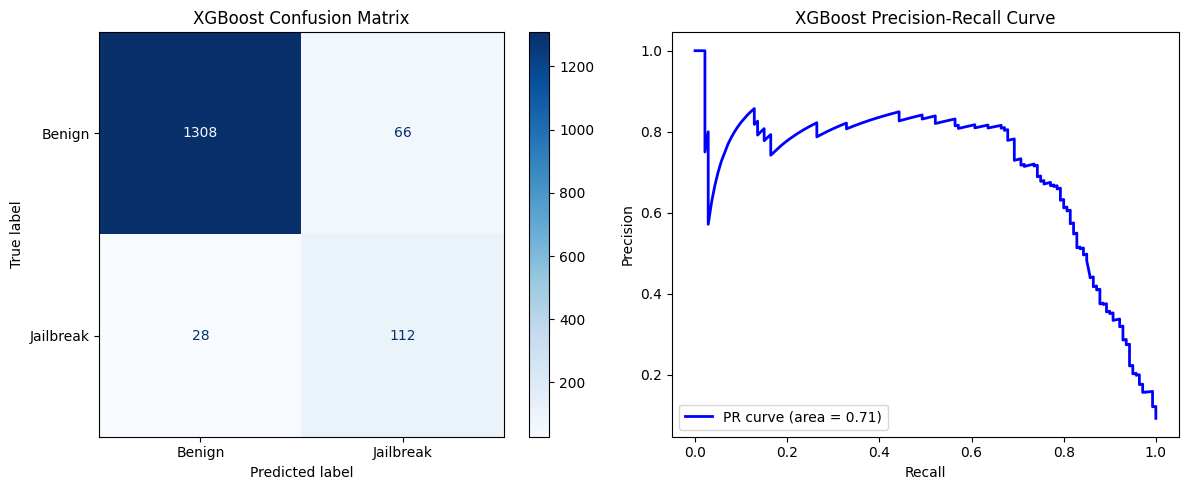

In [ ]:
# Final XGBoost
# Features: TF-IDF scores (max_features=3000)
# Parameters: scale_pos_weight=15, n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42

train_features_xgb = tfidf_train
test_features_xgb = tfidf_test

xgboost = XGBClassifier(scale_pos_weight=15, n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
xgboost.fit(train_features_xgb, train_df['jailbreak'])

y_pred_prob_xgb = xgboost.predict_proba(test_features_xgb)[:, 1]

results_xgb, fig_xgb = evaluation_metrics('XGBoost', y_pred_prob_xgb, test_df['jailbreak'], .4)

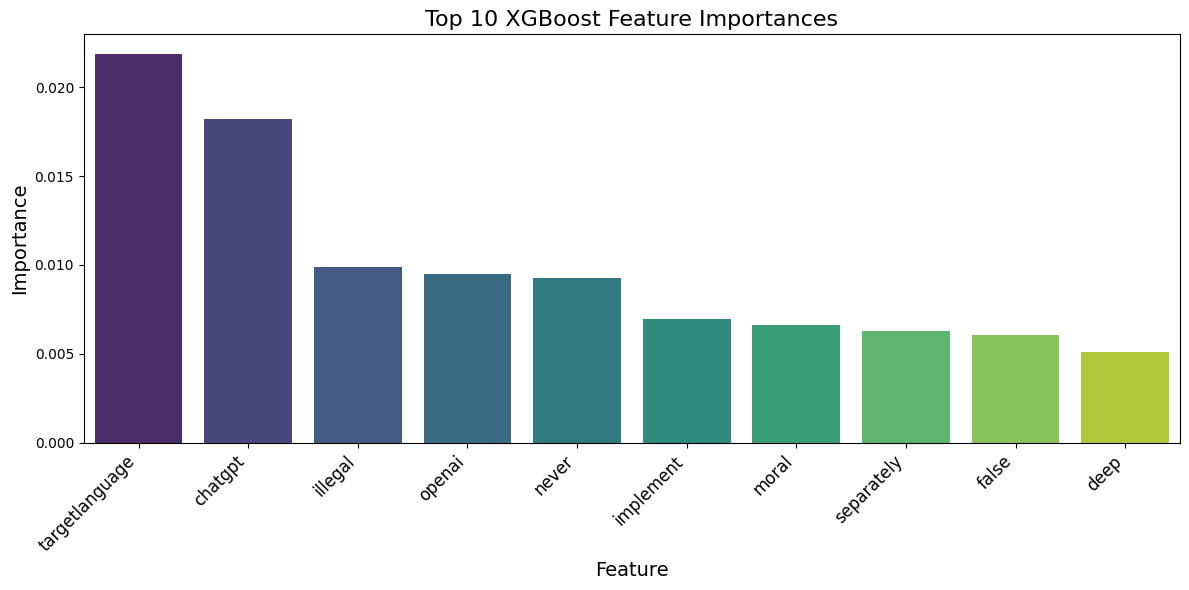

In [ ]:
visualize_top_10_features(xgboost, tfidf_feature_names, 'Top 10 XGBoost Feature Importances')

In [ ]:
# XGBoost Feature Importances

print("XGBoost Feature Importances")
print("---------------------------")
feature_importances(xgboost, tfidf_feature_names, top_n=10)

XGBoost Feature Importances
---------------------------
             Feature  Importance
2666  targetlanguage    0.021878
409          chatgpt    0.018230
1329         illegal    0.009872
1835          openai    0.009516
1778           never    0.009267
1346       implement    0.006962
1724           moral    0.006608
2385      separately    0.006276
1035           false    0.006072
689             deep    0.005088
